In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import rcParams

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = ["clean_trace", "std_phon_trace", "phonetic_trace","traces_fourier", "syllables_fourier"]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")

SAMPLING_RATE = 48_000/8

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

## Import

In [2]:
# Load dataset
df = pd.read_csv(DF_PREPROC_FILE)

# Load timeseries
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

## Average sti traces

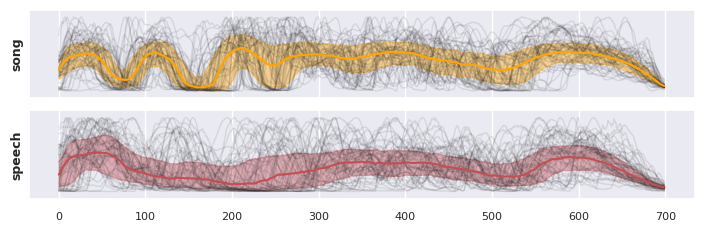

In [3]:
m = 90
fig, axes = plt.subplots(2, 1, sharex=True, figsize=default_style.SHORT_FULLSIZE_FIGURE)
for vc,ax,col in zip(["song", "speech"], axes, ["orange", "r"]):
    subsample = np.vstack(traces["std_phon_trace"][df.vocal_channel ==vc])
    
    examples = np.random.randint(len(subsample), size=50)
    for ex in examples:
        ax.plot(subsample[ex], color="k", alpha=0.1, lw=1)
        
    low, median, upper = np.quantile(subsample, [0.25, 0.5, 0.75], axis=0)

    ax.plot(median, color=col)
    ax.fill_between(np.arange(len(median)), low, upper, color=col, alpha=0.4)
    ax.set_ylabel(f"{vc}", fontdict=dict(weight="bold"))
    ax.set_yticks([])
    ax.set_ylim(-0.1,1.1)
    
    
plt.savefig("../images/average_sti.pdf")

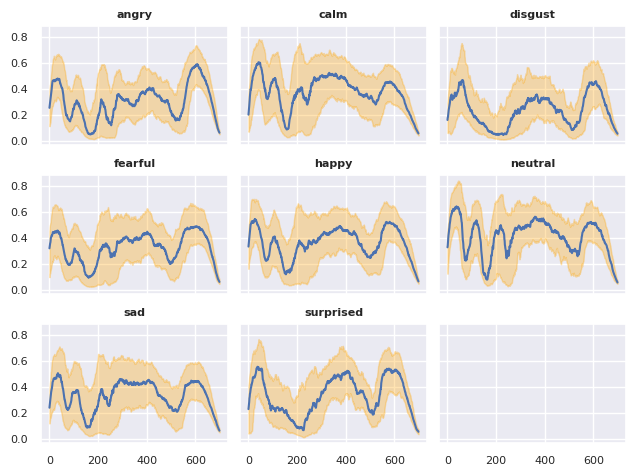

In [4]:
m = 90
fig, axes = plt.subplots(3,3, sharex=True, sharey=True)
axes = axes.flatten()
for vc,ax in zip(np.unique(df.emotion), axes):
    subsample = np.vstack(traces["std_phon_trace"][df.emotion ==vc])
    low, median, upper = np.quantile(subsample, [0.25, 0.5, 0.75], axis=0)

    ax.plot(median)
    ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{vc}")

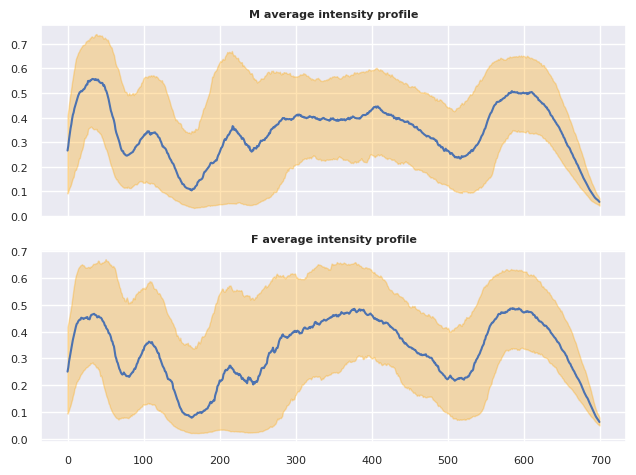

In [5]:
m = 90
fig, axes = plt.subplots(2, 1, sharex=True)
for s,ax in zip(["M", "F"], axes):
    subsample = np.vstack(traces["std_phon_trace"][df.sex == s])
    low, median, upper = np.quantile(subsample, [0.25, 0.5, 0.75], axis=0)

    ax.plot(median)
    ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{s} average intensity profile")

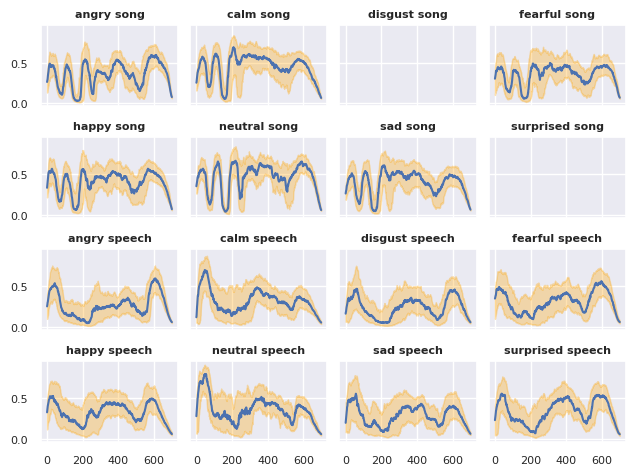

In [6]:
m = 90
fig, axes = plt.subplots(4,4, sharex=True, sharey=True)
axes = axes.flatten()

attrs = np.array([[ (vc, em) for em in np.unique(df.emotion)] for vc in np.unique(df.vocal_channel)]).reshape(-1,2)

for attr ,ax in zip(attrs, axes):
    subsample = traces["std_phon_trace"][(df.vocal_channel == attr[0])&(df.emotion==attr[1])]
    if len(subsample) > 0:
        subsample = np.vstack(subsample)
        low, median, upper = np.quantile(subsample, [0.25, 0.5, 0.75], axis=0)

        ax.plot(median)
        ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{attr[1]} {attr[0]}", fontdict=dict(weight="bold"))

## Motifs on clean traces

In [41]:
import stumpy
from matplotlib.patches import Rectangle

from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± m

window is 66.66666666666667 ms
Unnamed: 0                                                              1998
vocal_channel                                                           song
emotion                                                              neutral
emotional_intensity                                                   normal
statement                                                               dogs
repetition                                                               1st
actor                                                               actor_13
path                       ../dataset/Audio_Song_Actors_01-24/Actor_13/03...
sex                                                                        M
begin_s                                                             1.094667
end_s                                                                  3.437
fourier_coeffs             [1.7881393e-07 4.4782333e-02 8.0579042e-02 ......
filtered_fourier_coeffs    [1.7881393e-07 4.4

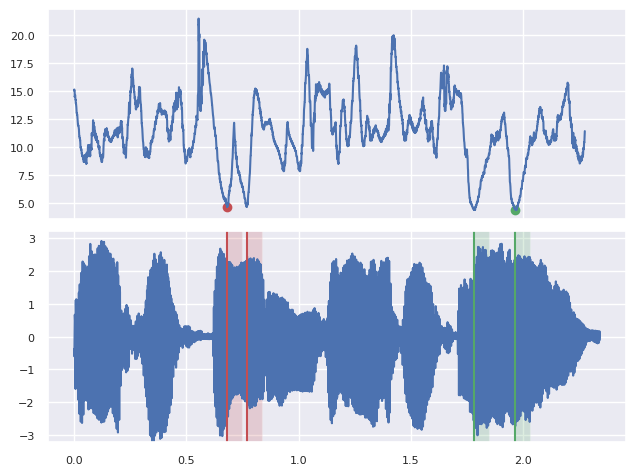

In [67]:
from scipy.signal import argrelmin, find_peaks

m = 400
## good ones:
# 1998 --> song
# 998 --> speech

test_track_index = 1998
test_track = traces['clean_trace'][test_track_index]
test_track = test_track[np.logical_not(np.isnan(test_track))]
time = np.linspace(0, len(test_track)/SAMPLING_RATE,len(test_track))


print(f"window is {m/SAMPLING_RATE*1e3} ms")
print(df.loc[test_track_index])


fig, (axmat, axts ) = plt.subplots(2,1,sharex=True)
axts.set_ylim(-1.1*np.max(test_track), 1.1*np.max(test_track))
axts.plot(time, test_track)


mp = stumpy.stump(test_track, m)
axmat.plot(np.linspace(0, len(mp)/SAMPLING_RATE, len(mp)), mp[:,0])

peaks = find_peaks(-mp[:, 0], distance=m, prominence=0)

motif_idxs = peaks[0]
motif_idxs = motif_idxs[np.flip(np.argsort(peaks[1]["prominences"]))]

colors = ["r", "g"]
done = 0
count = 0
nearest_neighbor_idx = -1
real_motifs = []



while done < len(colors):    
    motif_idx = motif_idxs[count]
    if motif_idx != nearest_neighbor_idx:
        nearest_neighbor_idx = mp[motif_idx, 1]
        real_motifs.append(motif_idx)
        print(f"motif {done} is in {motif_idx} --> {nearest_neighbor_idx}")
        axmat.scatter([motif_idx/SAMPLING_RATE], [mp[motif_idx, 0]], c=colors[done])

        axts.axvline(motif_idx/SAMPLING_RATE, color=colors[done])
        rect = Rectangle((motif_idx/SAMPLING_RATE, -20), m/SAMPLING_RATE, 40, facecolor=colors[done], alpha=0.2)
        axts.add_patch(rect)

        axts.axvline(nearest_neighbor_idx/SAMPLING_RATE, color=colors[done])
        rect = Rectangle((nearest_neighbor_idx/SAMPLING_RATE, -20), m/SAMPLING_RATE, 40, facecolor=colors[done], alpha=0.2)
        axts.add_patch(rect)
        
        count += 1 
        done += 1
    else:
        print(f"skipped {motif_idx} because is equal to nearest {nearest_neighbor_idx}")
        count +=1


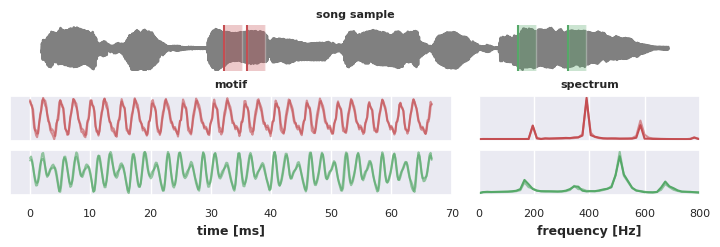

In [68]:
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq

scaler = StandardScaler()
pepo = lambda x: scaler.fit_transform(x.reshape(-1,1)).reshape(-1)

fig, axes = plt.subplot_mosaic([["trace","trace"],["mot1", "four1"],["mot2", "four2"]], 
                               width_ratios=[2,1],
                              figsize=default_style.SHORT_FULLSIZE_FIGURE,
                              layout="constrained"
                              )
axes["trace"].set_ylim(-1.1*np.max(test_track), 1.1*np.max(test_track))
time = np.linspace(0, len(test_track)/SAMPLING_RATE,len(test_track))
axes["trace"].plot(time, test_track, lw=2, color="gray", zorder=-1)

for i, (motif,  color) in enumerate(zip(real_motifs, ["r","g"])):
    
    nearest_neighbor_idx = mp[motif, 1]

    axes["trace"].axvline(motif/SAMPLING_RATE, color=color)
    rect = Rectangle((motif/SAMPLING_RATE, -20), m/SAMPLING_RATE, 40, facecolor=color, alpha=0.3)
    axes["trace"].add_patch(rect)

    axes["trace"].axvline(nearest_neighbor_idx/SAMPLING_RATE, color=color)
    rect = Rectangle((nearest_neighbor_idx/SAMPLING_RATE, -20), m/SAMPLING_RATE, 40, facecolor=color, alpha=0.3)
    axes["trace"].add_patch(rect)
    
    
    nearest_neighbor_idx = mp[motif, 1]
    time = np.linspace(0, m/SAMPLING_RATE, m)
    axes[f"mot{i+1}"].plot(1000*time, pepo(test_track[motif:motif+m]), color=color, label=f"motif {i+1}", alpha=0.6)
    axes[f"mot{i+1}"].plot(1000*time, pepo(test_track[nearest_neighbor_idx:nearest_neighbor_idx + m]), color=color, alpha=0.6)
    
    # Fourier transform
    freqs = fftfreq(m, 1/SAMPLING_RATE)
    
    signal_f = fft(pepo(test_track[motif:motif+m]))
    axes[f"four{i+1}"].plot(freqs[:m//2], 1/m*np.abs(signal_f[:m//2]), color=color)
    
    signal_f = fft(pepo(test_track[nearest_neighbor_idx:nearest_neighbor_idx + m]))
    axes[f"four{i+1}"].plot(freqs[:m//2],1/m* np.abs(signal_f[:m//2]), color=color, alpha=0.6)
    
    
    
    axes[f"four{i+1}"].set_xlim(0,800)
#     axes[f"four{i+1}"].set_ylim(0,1e0)

#     axes[f"four{i+1}"].set_yscale("log")

### Cutieries
axes["trace"].axis("off")

axes["mot1"].xaxis.set_ticklabels([])
axes["four1"].xaxis.set_ticklabels([])

axes["four1"].set_yticks([])
axes["four2"].set_yticks([])

axes["mot1"].set_yticks([])
axes["mot2"].set_yticks([])


axes["mot1"].set_title("motif")
axes["four1"].set_title("spectrum")
axes["mot2"].set_xlabel("time [ms]");
axes["four2"].set_xlabel("frequency [Hz]");

axes["trace"].set_title(f"{df.vocal_channel[test_track_index]} sample")
fig.savefig(f"../images/motif_traces_{df.vocal_channel[test_track_index]}.pdf")


## Motifs on standardised short-time intensities

motif 0 is in 427 --> 188
skipped 188 because is equal to nearest 188
motif 1 is in 256 --> 522


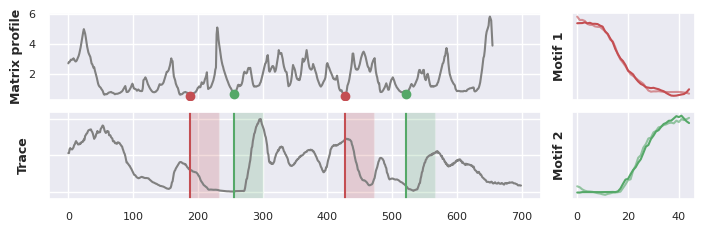

In [10]:
from scipy.signal import argrelmin, find_peaks
from sklearn.preprocessing import StandardScaler

m = 45
test_track = traces['std_phon_trace'][60]

fig, axes = plt.subplot_mosaic([["profile", "motif1"], ["trace", "motif2"]], 
                             width_ratios=[4,1], 
                             sharex=False, sharey=False,
                            figsize=default_style.SHORT_FULLSIZE_FIGURE)

axes["trace"].set_ylim(-0.1, 1.1*np.max(test_track))
axes["trace"].plot(test_track, color="gray")


mp = stumpy.stump(test_track, m)
axes["profile"].plot(mp[:,0], color="gray")

peaks = find_peaks(-mp[:, 0], distance=m//3, prominence=0)

motif_idxs = peaks[0]
motif_idxs = motif_idxs[np.flip(np.argsort(peaks[1]["prominences"]))]

colors = ["r", "g"]
done = 0
count = 0
nearest_neighbor_idx = -1
real_motifs = []

while done < len(colors):    
    motif_idx = motif_idxs[count]
    if motif_idx != nearest_neighbor_idx:
        nearest_neighbor_idx = mp[motif_idx, 1]
        real_motifs.append(motif_idx)
        print(f"motif {done} is in {motif_idx} --> {nearest_neighbor_idx}")
        
        axes["profile"].scatter([motif_idx], [mp[motif_idx, 0]], c=colors[done], zorder=4)
        axes["profile"].scatter([nearest_neighbor_idx], [mp[nearest_neighbor_idx, 0]], c=colors[done], zorder=4)

        axes["trace"].axvline(motif_idx, color=colors[done])
        rect = Rectangle((motif_idx, -1), m, 3, facecolor=colors[done], alpha=0.2)
        axes["trace"].add_patch(rect)

        axes["trace"].axvline(nearest_neighbor_idx, color=colors[done])
        rect = Rectangle((nearest_neighbor_idx, -1), m, 40, facecolor=colors[done], alpha=0.2)
        axes["trace"].add_patch(rect)
        
        count += 1 
        done += 1
    else:
        print(f"skipped {motif_idx} because is equal to nearest {nearest_neighbor_idx}")
        count +=1

        
# Plot motifs
scaler = StandardScaler()
pepo = lambda x: scaler.fit_transform(x.reshape(-1,1)).reshape(-1)


for i, (motif,  color) in enumerate(zip(real_motifs, ["r","g"])):
    nearest_neighbor_idx = mp[motif, 1]

    axes[f"motif{i+1}"].plot(pepo(test_track[motif:motif+m]), color=color, label=f"motif {i+1}")
    axes[f"motif{i+1}"].plot(pepo(test_track[nearest_neighbor_idx:nearest_neighbor_idx + m]), color=color, alpha=0.6)
    
## Cutieries
axes["profile"].axes.xaxis.set_ticklabels([])
axes["trace"].axes.yaxis.set_ticklabels([])

axes["motif1"].axes.xaxis.set_ticklabels([])
axes["motif1"].set_yticks([])
axes["motif2"].set_yticks([])

axes["profile"].set_ylabel("Matrix profile", fontdict=dict(weight="bold"))
axes["trace"].set_ylabel("Trace", fontdict=dict(weight="bold"))
axes["motif1"].set_ylabel("Motif 1",fontdict=dict(weight="bold"))
axes["motif2"].set_ylabel("Motif 2",fontdict=dict(weight="bold"))


axes["trace"].set_xlim(-30, len(test_track)+30)
axes["profile"].set_xlim(-30, len(test_track)+30)

plt.savefig("../images/motifs1.pdf")

Text(0.5, 1.0, 'Global average matrix profile')

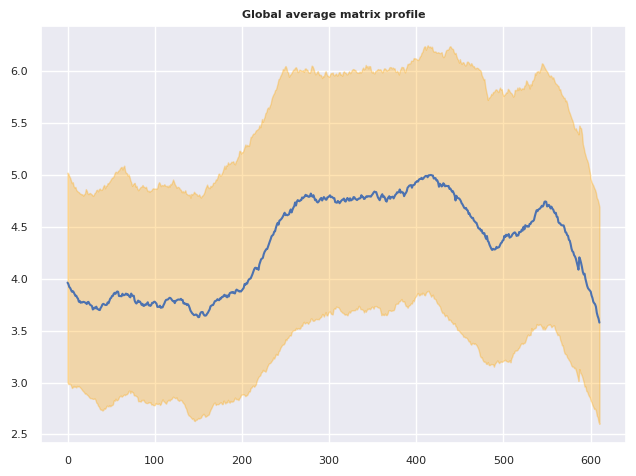

In [11]:
M = len(traces["std_phon_trace"])
m = 90

matrix_profiles = np.zeros((M, len(traces["std_phon_trace"][i])-m+1    ))

for i in range(M):
    matrix_profiles[i] = stumpy.stump(traces["std_phon_trace"][i], m)[:, 0]
    
low, median, upper = np.quantile(matrix_profiles, [0.25, 0.5, 0.75], axis=0)

plt.plot(median)
plt.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
plt.title("Global average matrix profile")

## Average motifs

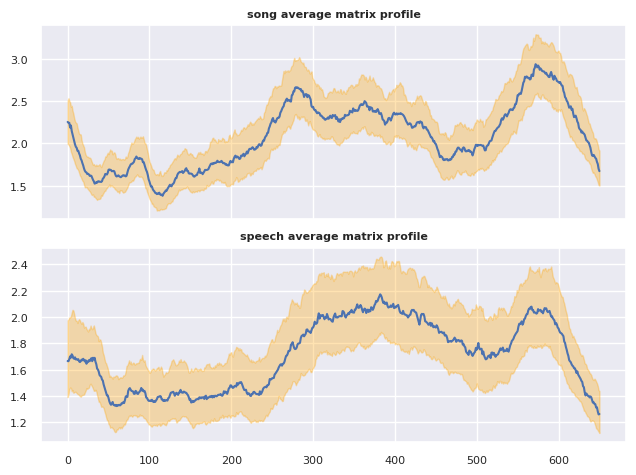

In [69]:
m = 50
fig, axes = plt.subplots(2, 1, sharex=True)
for vc,ax in zip(["song", "speech"], axes):
    subsample = traces["std_phon_trace"][df.vocal_channel ==vc]
    M = len(subsample)
    matrix_profiles = np.zeros((M, len(traces["std_phon_trace"][i])-m+1  ))

    for i in range(M):
        matrix_profiles[i] = stumpy.stump(subsample[i], m)[:, 0]

    low, median, upper = np.quantile(matrix_profiles, [0.4, 0.5, 0.6], axis=0)

    ax.plot(median)
    ax.fill_between(np.arange(len(median)), low, upper, color="orange", alpha=0.3)
    ax.set_title(f"{vc} average matrix profile")